In [1]:
import pandas, seaborn, scipy, numpy, matplotlib, sklearn, collections, itertools, math, functools, sys

%matplotlib inline
from matplotlib import pyplot
matplotlib.rc("savefig", dpi=800)
#matplotlib.rc("savefig", dpi=72)

from sklearn import preprocessing

# Constants
library_sizes = {
    'WGS': 3002000000,
    'WES': 50160183,
}
mhc_binding_threshold_affinity = 500

def bootstrap(values, statistic=numpy.mean, samples=5000):
    values = pandas.Series(values).dropna()
    if len(values) <= 1:
        return (numpy.nan, numpy.nan)
    values = [statistic(sklearn.utils.resample(values)) for i in range(samples)]
    return (numpy.percentile(values, 5), numpy.percentile(values, 95))

def round_to_n(x, n):
    return round(x, -int(math.floor(math.log10(x))) + (n - 1)) 

def mean_with_errorbars(values, decimals=0):
    pattern = "%%0.%df" % decimals
    bars = bootstrap(values)
    if numpy.nan in bars:
        return pattern % numpy.mean(values)
    if decimals == 0:
        bars = (round_to_n(bars[0], 2), round_to_n(bars[1], 2)) 
    return (pattern + " (" + pattern + " - " + pattern + ")") % ((numpy.mean(values),) + bars)

pandas.set_option('display.max_columns', 500)


def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')

/Users/tim/venvs/analysis-venv-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/tim/venvs/analysis-venv-2.7/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [107]:
model_inputs = {}

In [109]:
def canonicalize(x):
    (first, second) = x.split(">")
    assert len(first) == len(second) == 3
    assert first[0] == second[0]
    assert first[2] == second[2]
    return "%s[%s>%s]%s" % (first[0], first[1], second[1], first[2])

chicken_counts_df = pandas.read_csv("../data/chicken_mutation_counts_trinucleotide.csv", skiprows=4).dropna()
del chicken_counts_df["Clone"]
del chicken_counts_df["Total"]
chicken_counts_df.columns = ["Treatment"] + [canonicalize(x) for x in chicken_counts_df.columns[1:]]
context_columns = list(chicken_counts_df.columns[1:])
chicken_counts_df

for treatment in ['cisplatin', 'cyclophosphamide', 'etoposide']:
    combined_df = chicken_counts_df.ix[chicken_counts_df.Treatment.isin(["mock", treatment])].copy()
    treated_series = combined_df.Treatment == treatment
    del combined_df["Treatment"]

    data = {
        'num_sources': combined_df.shape[0],
        'num_contexts': combined_df.shape[1],
        'counts': combined_df.values.astype(int),
        'treated': treated_series.values.astype(int),
    }
    model_inputs['chicken %s' % treatment] = data
model_inputs.keys()

['chicken cyclophosphamide', 'chicken etoposide', 'chicken cisplatin']

In [110]:
worm_raw_df = pandas.read_csv("../data/c_elegans_substitutions.csv")
worm_raw_df["context_mutation_3p5p"] = (
    worm_raw_df.CONTEXT.str.slice(2, 3)
    + "[" + worm_raw_df.MUT_TYPE + "]"
    + worm_raw_df.CONTEXT.str.slice(4, 5))
worm_raw_df = worm_raw_df.ix[(worm_raw_df.Drug.isin(["None", "Cisplatin"]))]
worm_counts_df = (
    worm_raw_df.groupby(["Genotype", "Drug", "Concentration", "ID", "context_mutation_3p5p"])
    .Genotype.count().unstack('context_mutation_3p5p')
    .fillna(0))
assert all(c in context_columns for c in worm_counts_df.columns)
worm_counts_df = worm_counts_df.T.ix[context_columns].T.fillna(0)
worm_counts_df = worm_counts_df.reset_index()
worm_counts_df["treated"] = worm_counts_df.Concentration > 0
treated_genotypes = worm_counts_df.groupby(["Genotype"]).treated.nunique() > 1
worm_counts_df = worm_counts_df.ix[worm_counts_df.Genotype.isin(
        list(treated_genotypes.index[treated_genotypes]))]
worm_counts_df["Treatment"] = [
    "mock" if not row.treated else "%s" % (row.Drug,)
    for (i, row) in worm_counts_df.iterrows()
]
worm_counts_df = worm_counts_df[["Genotype", "Treatment"] + context_columns]
worm_counts_df

context_mutation_3p5p,Genotype,Treatment,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,G[C>T]A,G[C>T]C,G[C>T]G,G[C>T]T,T[C>T]A,T[C>T]C,T[C>T]G,T[C>T]T,A[T>A]A,A[T>A]C,A[T>A]G,A[T>A]T,C[T>A]A,C[T>A]C,C[T>A]G,C[T>A]T,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
0,N2,Cisplatin,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,N2,Cisplatin,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,N2,Cisplatin,0,0,0,0,0,4,0,2,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,N2,Cisplatin,0,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,N2,Cisplatin,0,0,0,1,1,3,0,0,0,0,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,N2,mock,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,N2,mock,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,N2,mock,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,N2,mock,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,N2,mock,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [115]:
for (genotype, sub_worm_df) in worm_counts_df.groupby("Genotype"):
    sub_worm_df = sub_worm_df.copy()
    del sub_worm_df["Genotype"]
    for treatment in ["Cisplatin"]:
        combined_df = sub_worm_df.ix[sub_worm_df.Treatment.isin(["mock", treatment])].copy()
        treated_series = combined_df.Treatment == treatment
        del combined_df["Treatment"]

        data = {
            'num_sources': combined_df.shape[0],
            'num_contexts': combined_df.shape[1],
            'counts': combined_df.values.astype(int),
            'treated': treated_series.values.astype(int),
        }
        model_inputs['worm %s %s' % (genotype, treatment)] = data
model_inputs.keys()

['worm polq-1 Cisplatin',
 'worm slx-1 Cisplatin',
 'worm fan-1 Cisplatin',
 'chicken etoposide',
 'worm fcd-2 Cisplatin',
 'worm lig-4; fcd-2 Cisplatin',
 'chicken cyclophosphamide',
 'worm mus-81 Cisplatin',
 'worm lig-4 Cisplatin',
 'worm xpf-1 Cisplatin',
 'worm N2 Cisplatin',
 'chicken cisplatin']

In [13]:
import pystan, time
FIT_CACHE={}
def run_stan(model_code, *args, **kwargs):
    kwargs = dict(kwargs)
    kwargs['model_code'] = model_code
    if 'n_jobs' not in kwargs:
        kwargs['n_jobs'] = -1
    if model_code in FIT_CACHE:
        print("Reusing fit.")
        kwargs['fit'] = FIT_CACHE[model_code]
    else:
        print("NOT reusing fit.")
    start = time.time()
    FIT_CACHE[model_code] = pystan.stan(*args, **kwargs)
    print("Ran in %0.3f sec." % (time.time() - start))
    return FIT_CACHE[model_code]



In [116]:
# stan model
model1 = """
data {
    // Data sizes
    int<lower=0> num_sources;
    int<lower=0> num_contexts;

    // Data
    int<lower=0> counts[num_sources, num_contexts];
    int<lower=0,upper=1> treated[num_sources];
}
parameters {
    vector<lower=0>[num_contexts] untreated_rates;
    vector<lower=0>[num_contexts] treated_rates;
}
model {
    for (i in 1:num_sources) {
        counts[i] ~ poisson(untreated_rates + treated[i] * treated_rates);
    }
}
""".strip()

def init(data):
    return {
        'untreated_rates': numpy.ones(len(context_columns), dtype=int),
        'treated_rates': numpy.ones(len(context_columns), dtype=int),
    }

for (i, line) in enumerate(model1.split("\n")):
    print("%3d %s" % (i + 1, line))

def print_dict(d):
    for key in [key for key in d if not isinstance(d[key], numpy.ndarray)]:
        print("%s: %s" % (key, d[key]))
    for key in [key for key in d if isinstance(d[key], numpy.ndarray)]:
        print("%s: %s mean=%s std=%s" % (key,  d[key].shape, d[key].mean(), d[key].std()))

fit_results = {}
for (label, data) in model_inputs.items():
    print("+" * 40)
    print("RUNNING MODEL FOR: %s" % label)
    print("")
    print("*" * 40)
    print("DATA")
    print_dict(data)
    print("")

    print("*" * 40)
    print("INITIAL VALUES")
    print_dict(init(data))
    sys.stdout.flush()
    
    fit_results[label] = run_stan(model_code=model1, data=data, init=lambda: init(data), iter=1000, chains=2)
    print("Done with fit.")
print("DONE")


  1 data {
  2     // Data sizes
  3     int<lower=0> num_sources;
  4     int<lower=0> num_contexts;
  5 
  6     // Data
  7     int<lower=0> counts[num_sources, num_contexts];
  8     int<lower=0,upper=1> treated[num_sources];
  9 }
 10 parameters {
 11     vector<lower=0>[num_contexts] untreated_rates;
 12     vector<lower=0>[num_contexts] treated_rates;
 13 }
 14 model {
 15     for (i in 1:num_sources) {
 16         counts[i] ~ poisson(untreated_rates + treated[i] * treated_rates);
 17     }
 18 }
++++++++++++++++++++++++++++++++++++++++
RUNNING MODEL FOR: worm polq-1 Cisplatin

****************************************
DATA
num_sources: 8
num_contexts: 96
counts: (8, 96) mean=0.08203125 std=0.28829607008
treated: (8,) mean=0.75 std=0.433012701892

****************************************
INITIAL VALUES
treated_rates: (96,) mean=1.0 std=0.0
untreated_rates: (96,) mean=1.0 std=0.0
Reusing fit.
Ran in 2.247 sec.
Done with fit.
++++++++++++++++++++++++++++++++++++++++
RUNNING MODEL F

In [118]:
fit_counts_means = []
fit_counts_means_index = []
for (label, results) in fit_results.items():
    fit_counts_means_index.append(label)
    fit_counts_means.append(results.extract()['treated_rates'].mean(0))

mean_rates_df = pandas.DataFrame(fit_counts_means, index=fit_counts_means_index, columns=context_columns)
mean_rates_df

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,G[C>T]A,G[C>T]C,G[C>T]G,G[C>T]T,T[C>T]A,T[C>T]C,T[C>T]G,T[C>T]T,A[T>A]A,A[T>A]C,A[T>A]G,A[T>A]T,C[T>A]A,C[T>A]C,C[T>A]G,C[T>A]T,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
worm polq-1 Cisplatin,0.353783,0.261908,0.367190,0.164665,0.164598,0.573198,0.167134,0.722755,0.261696,0.369472,0.168299,0.166979,0.171331,0.164464,0.262482,0.256035,0.167137,0.267985,0.163883,0.245529,0.166054,0.172629,0.163712,0.171052,0.268113,0.168725,0.163481,0.166326,0.172862,0.164504,0.267678,0.160498,0.162460,0.166348,0.175215,0.165491,0.164863,0.162947,0.372799,0.230520,0.167795,0.261690,0.260073,0.171841,0.259464,0.270413,0.176582,0.172324,0.358044,0.166112,0.261306,0.267815,0.257665,0.156776,0.174543,0.174864,0.249756,0.168747,0.171652,0.172372,0.257495,0.259301,0.170520,0.169110,0.492678,0.166816,0.162205,0.169541,0.159223,0.261231,0.172406,0.166431,0.166993,0.177513,0.170945,0.361159,0.241583,0.264434,0.162406,0.163342,0.173233,0.163557,0.266354,0.264413,0.162952,0.165041,0.166029,0.163929,0.164150,0.164849,0.293703,0.252024,0.172783,0.250906,0.171533,0.264440
worm slx-1 Cisplatin,0.264435,0.272224,0.166997,0.169882,0.267927,0.907567,0.171398,1.043440,0.171465,0.264085,0.166360,0.511667,0.166968,0.260454,0.176059,0.166332,0.166806,0.170283,0.168821,0.166082,0.167642,0.159503,0.159696,0.166985,0.279559,0.163987,0.165095,0.168090,0.166808,0.161066,0.161846,0.264984,0.166583,0.165889,0.172109,0.166055,0.166972,0.262934,0.170064,0.261763,0.161484,0.174247,0.166183,0.381613,0.166038,0.160926,0.162049,0.166713,0.274268,0.168172,0.262594,0.167130,0.161809,0.380052,0.163124,0.164950,0.172369,0.171316,0.175702,0.167523,0.168889,0.273702,0.264145,0.159174,0.169623,0.169699,0.165294,0.394327,0.160914,0.263092,0.169783,0.269960,0.160545,0.170853,0.163808,0.265104,0.260095,0.163077,0.166757,0.755564,0.166337,0.173963,0.164841,0.168877,0.169081,0.164228,0.169426,0.166170,0.166309,0.164652,0.163830,0.161966,0.162317,0.176481,0.167975,0.166658
worm fan-1 Cisplatin,0.252340,0.172731,0.165266,0.163317,0.176132,0.715116,0.168413,0.590879,0.261988,0.306396,0.256070,0.726961,0.264467,0.163901,0.168024,0.171387,0.171100,0.179035,0.162020,0.166933,0.168658,0.269444,0.165193,0.167648,0.168079,0.162781,0.161239,0.165824,0.164212,0.162944,0.159903,0.172576,0.162614,0.166201,0.170743,0.166539,0.159784,0.166826,0.167121,0.254469,0.262108,0.161650,0.161906,0.169457,0.265912,0.163317,0.169702,0.377444,0.172960,0.167733,0.171331,0.268241,0.263087,0.164331,0.168591,0.264241,0.164992,0.173147,0.171105,0.265940,0.374215,0.170437,0.155401,0.157173,0.165797,0.174208,0.166934,0.166785,0.230254,0.156327,0.167380,0.579442,0.158722,0.170040,0.163345,0.167699,0.170380,0.247365,0.163424,0.261717,0.166298,0.168303,0.162539,0.163786,0.168895,0.170285,0.165349,0.162786,0.170832,0.161100,0.163153,0.161963,0.169232,0.166761,0.174801,0.259959
chicken etoposide,1.312913,0.865915,0.513721,0.620533,1.053969,0.326841,0.560687,0.720854,1.541158,0.565356,0.325292,0.999226,1.131379,1.386116,0.569229,1.322985,1.776948,0.332043,0.540179,0.861604,0.556084,0.335527,0.580378,0.515748,0.746207,0.332346,0.578436,0.720083,0.494378,0.317259,0.332622,0.709562,0.634532,1.366430,2.175886,0.797366,1.245310,0.434715,2.027377,0.665969,1.465448,1.338944,2.563623,2.105722,0.403633,0.759474,0.720354,0.710189,0.731912,0.652241,0.323933,0.475259,0.343224,1.268229,0.749583,1.437364,0.709151,0.839551,0.766270,1.342003,0.604065,0.833575

In [133]:
chicken_trinucleotide_frequencies = pandas.read_csv("../data/chicken_trinucleotide_frequencies.csv", skiprows=4, index_col=0)
chicken_trinucleotide_frequencies = chicken_trinucleotide_frequencies[list(chicken_trinucleotide_frequencies.columns)[:3]].dropna()
chicken_trinucleotide_frequencies

c_elegans_trinucleotide_frequencies = pandas.read_csv("../data/c_elegans.trinucleotides.csv", index_col='context')
assert set(c_elegans_trinucleotide_frequencies.index) == set(chicken_trinucleotide_frequencies.index)
c_elegans_trinucleotide_frequencies = c_elegans_trinucleotide_frequencies.ix[chicken_trinucleotide_frequencies.index]
assert list(c_elegans_trinucleotide_frequencies.index) == list(chicken_trinucleotide_frequencies.index)
c_elegans_trinucleotide_frequencies
c_elegans_trinucleotide_frequencies.columns = ["C elegans"]

trinucleotide_frequencies = pandas.merge(
    chicken_trinucleotide_frequencies,
    c_elegans_trinucleotide_frequencies,
    left_index=True,
    right_index=True)
del trinucleotide_frequencies["Human/chicken ratio"]
trinucleotide_frequencies.columns = trinucleotide_frequencies.columns.map({
        "Gallus gallus": "chicken",
        "Homo sapiens": "human",
        "C elegans": "worm",
    }.get)
trinucleotide_frequencies

,chicken,human,worm
ACA,0.043165,0.040337,0.036124
ACC,0.021226,0.023258,0.017362
ACG,0.006771,0.005026,0.016543
ACT,0.033155,0.032173,0.030348
CCA,0.033537,0.036888,0.025531
CCC,0.023988,0.026295,0.011433
CCG,0.005774,0.005522,0.013242
CCT,0.033154,0.035518,0.017187
GCA,0.037486,0.028803,0.022975
GCC,0.020606,0.023797,0.013029


['ACA',
 'ACC',
 'ACG',
 'ACT',
 'CCA',
 'CCC',
 'CCG',
 'CCT',
 'GCA',
 'GCC',
 'GCG',
 'GCT',
 'TCA',
 'TCC',
 'TCG',
 'TCT',
 'ACA',
 'ACC',
 'ACG',
 'ACT',
 'CCA',
 'CCC',
 'CCG',
 'CCT',
 'GCA',
 'GCC',
 'GCG',
 'GCT',
 'TCA',
 'TCC',
 'TCG',
 'TCT',
 'ACA',
 'ACC',
 'ACG',
 'ACT',
 'CCA',
 'CCC',
 'CCG',
 'CCT',
 'GCA',
 'GCC',
 'GCG',
 'GCT',
 'TCA',
 'TCC',
 'TCG',
 'TCT',
 'ATA',
 'ATC',
 'ATG',
 'ATT',
 'CTA',
 'CTC',
 'CTG',
 'CTT',
 'GTA',
 'GTC',
 'GTG',
 'GTT',
 'TTA',
 'TTC',
 'TTG',
 'TTT',
 'ATA',
 'ATC',
 'ATG',
 'ATT',
 'CTA',
 'CTC',
 'CTG',
 'CTT',
 'GTA',
 'GTC',
 'GTG',
 'GTT',
 'TTA',
 'TTC',
 'TTG',
 'TTT',
 'ATA',
 'ATC',
 'ATG',
 'ATT',
 'CTA',
 'CTC',
 'CTG',
 'CTT',
 'GTA',
 'GTC',
 'GTG',
 'GTT',
 'TTA',
 'TTC',
 'TTG',
 'TTT']

In [145]:
normalization_trinucleotides = [
    x[0] + x[2] + x[-1]
    for x in context_columns
]
normalization_trinucleotides

def human_normalize_row(label, row):
    species = label.split()[0]
    occurrences = trinucleotide_frequencies[species].ix[normalization_trinucleotides]
    human_occurrences = trinucleotide_frequencies["human"].ix[normalization_trinucleotides]
    human_unnormalized = (row.values / occurrences.values) * human_occurrences.values
    return human_unnormalized / human_unnormalized.sum()

human_normalized_rates = pandas.DataFrame([
        human_normalize_row(i, row)
        for (i, row) in mean_rates_df.iterrows()
    ], index=mean_rates_df.index, columns=mean_rates_df.columns)
human_normalized_rates

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,G[C>T]A,G[C>T]C,G[C>T]G,G[C>T]T,T[C>T]A,T[C>T]C,T[C>T]G,T[C>T]T,A[T>A]A,A[T>A]C,A[T>A]G,A[T>A]T,C[T>A]A,C[T>A]C,C[T>A]G,C[T>A]T,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
worm polq-1 Cisplatin,0.016772,0.014896,0.004736,0.007412,0.010096,0.055970,0.002959,0.063414,0.013929,0.028650,0.003141,0.009775,0.006442,0.008447,0.002219,0.012801,0.007923,0.015242,0.002114,0.011051,0.010186,0.016856,0.002899,0.015008,0.014270,0.013083,0.003051,0.009737,0.006499,0.008449,0.002263,0.008024,0.007702,0.009461,0.002260,0.007449,0.010113,0.015911,0.006600,0.020226,0.008931,0.020292,0.004853,0.010060,0.009756,0.013889,0.001493,0.008616,0.015134,0.005740,0.011990,0.007908,0.013530,0.009127,0.012424,0.008210,0.010709,0.007460,0.009683,0.005709,0.010670,0.008019,0.005661,0.005292,0.020824,0.005764,0.007443,0.005006,0.008361,0.015208,0.012272,0.007814,0.007160,0.007847,0.009643,0.011961,0.010011,0.008178,0.005392,0.005112,0.007322,0.005652,0.012222,0.007808,0.008557,0.009608,0.011818,0.007696,0.007038,0.007287,0.016568,0.008347,0.007160,0.007760,0.005695,0.008275
worm slx-1 Cisplatin,0.011954,0.014764,0.002054,0.007292,0.015672,0.084507,0.002894,0.087303,0.008703,0.019528,0.002960,0.028564,0.005987,0.012757,0.001419,0.007930,0.007541,0.009235,0.002076,0.007129,0.009806,0.014852,0.002696,0.013971,0.014189,0.012126,0.002938,0.009384,0.005981,0.007889,0.001305,0.012634,0.007531,0.008997,0.002117,0.007127,0.009767,0.024483,0.002871,0.021901,0.008196,0.012885,0.002957,0.021303,0.005953,0.007882,0.001306,0.007948,0.011055,0.005541,0.011490,0.004706,0.008103,0.021099,0.011072,0.007385,0.007048,0.007222,0.009452,0.005291,0.006674,0.008072,0.008362,0.004750,0.006837,0.005592,0.007233,0.011104,0.008058,0.014606,0.011524,0.012087,0.006564,0.007202,0.008812,0.008372,0.010278,0.004809,0.005279,0.022547,0.006704,0.005732,0.007213,0.004755,0.008467,0.009117,0.011500,0.007440,0.006800,0.006941,0.008813,0.005115,0.006414,0.005205,0.005318,0.004973
worm fan-1 Cisplatin,0.012207,0.010025,0.002175,0.007501,0.011025,0.071253,0.003043,0.052903,0.014229,0.024244,0.004876,0.043426,0.010147,0.008590,0.001449,0.008744,0.008277,0.010391,0.002132,0.007667,0.010557,0.026847,0.002984,0.015010,0.009129,0.012880,0.003070,0.009906,0.006300,0.008540,0.001379,0.008804,0.007866,0.009646,0.002247,0.007649,0.010001,0.016622,0.003019,0.022783,0.014236,0.012791,0.003083,0.010123,0.010202,0.008560,0.001464,0.019256,0.007460,0.005914,0.008022,0.008083,0.014097,0.009762,0.012245,0.012660,0.007219,0.007810,0.009850,0.008987,0.015824,0.005379,0.005265,0.005019,0.007151,0.006143,0.007816,0.005026,0.012338,0.009287,0.012157,0.027761,0.006944,0.007670,0.009403,0.005667,0.007205,0.007806,0.005536,0.008357,0.007173,0.005934,0.007611,0.004935,0.009050,0.010116,0.012010,0.007799,0.007474,0.007267,0.009392,0.005474,0.007156,0.005263,0.005922,0.008301
chicken etoposide,0.014564,0.011263,0.004526,0.007148,0.013761,0.004253,0.006365,0.009167,0.014057,0.007750,0.003354,0.009515,0.013220,0.016582,0.006705,0.015701,0.019711,0.004319,0.004759,0.009925,0.007260,0.004366,0.006589,0.006559,0.006806,0.004556,0.005965,0.006857,0.005777,0.003795,0.003918,0.008421,0.007039,0.017774,0.019171,0.009185,0.016259,0.005657,0.023016,0.008469,0.013366,0.018355,0.026437,0.020052,0.004716,0.009086,0.008485,0.008428,0.010405,0.007742,0.003826,0.006311,0.004541,0.016005,0.007506,0.015997,0.008117,0.010089,0.008809,0.014940,0.007821,0.009271

In [155]:
def canonicalize_label(label):
    pieces = label.replace("N2", "wildtype").split()
    pieces[0] = {'worm': "C. Elegans", "chicken": "Gallus gallus"}[pieces[0]]
    return pieces[-1][0].upper() + pieces[-1][1:].lower() + ": " + " ".join(pieces[:-1])

human_normalized_rates_canonicalized = human_normalized_rates.copy()
human_normalized_rates_canonicalized.index = [
    canonicalize_label(x) for x in human_normalized_rates_canonicalized.index
]
human_normalized_rates_canonicalized = human_normalized_rates_canonicalized.ix[
    sorted(human_normalized_rates_canonicalized.index, key=lambda x: ('gallus' not in x, 'wildtype' not in x, x))
]
human_normalized_rates_canonicalized

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,G[C>T]A,G[C>T]C,G[C>T]G,G[C>T]T,T[C>T]A,T[C>T]C,T[C>T]G,T[C>T]T,A[T>A]A,A[T>A]C,A[T>A]G,A[T>A]T,C[T>A]A,C[T>A]C,C[T>A]G,C[T>A]T,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Cisplatin: Gallus gallus,0.005744,0.103134,0.000471,0.023438,0.021983,0.064583,0.000996,0.021657,0.008654,0.144093,0.001963,0.022779,0.006676,0.127979,0.001031,0.039935,0.002793,0.002310,0.000300,0.003858,0.004706,0.003341,0.001013,0.002880,0.004337,0.010135,0.000620,0.001591,0.003252,0.004312,0.001745,0.005962,0.001794,0.005851,0.000675,0.001815,0.005157,0.006467,0.001169,0.006631,0.004773,0.007534,0.001483,0.007332,0.002959,0.010036,0.001274,0.012620,0.006809,0.042435,0.004268,0.003535,0.022269,0.015703,0.016903,0.014542,0.001551,0.015914,0.001190,0.003062,0.005942,0.013058,0.004778,0.004880,0.002181,0.004709,0.001056,0.002088,0.003038,0.005318,0.006158,0.007073,0.001628,0.002219,0.000761,0.002285,0.001695,0.003332,0.001973,0.002346,0.001871,0.001076,0.005628,0.000919,0.005272,0.001944,0.011034,0.002576,0.000404,0.001826,0.005372,0.001975,0.001331,0.000664,0.005402,0.002167
Cyclophosphamide: Gallus gallus,0.005485,0.006816,0.001085,0.008642,0.004228,0.003533,0.002310,0.007084,0.002011,0.002096,0.002091,0.003298,0.004736,0.003685,0.001378,0.007533,0.003212,0.002354,0.001082,0.003672,0.002672,0.001576,0.001344,0.001563,0.002371,0.001650,0.001201,0.006512,0.002021,0.007669,0.001403,0.003138,0.010669,0.026143,0.002383,0.019231,0.014934,0.038182,0.007164,0.019391,0.005879,0.026425,0.003785,0.014934,0.004617,0.016043,0.002970,0.027825,0.012691,0.008577,0.017426,0.031515,0.017146,0.026724,0.036074,0.094065,0.017238,0.004705,0.011754,0.026406,0.031409,0.009848,0.019388,0.066488,0.003492,0.009067,0.009689,0.009760,0.004623,0.004378,0.003972,0.014565,0.004629,0.005451,0.003641,0.017788,0.004614,0.002973,0.005335,0.015162,0.003056,0.003739,0.004201,0.004268,0.014734,0.003721,0.005645,0.021125,0.003486,0.002573,0.002442,0.002677,0.006018,0.007306,0.002395,0.011994
Etoposide: Gallus gallus,0.014564,0.011263,0.004526,0.007148,0.013761,0.004253,0.006365,0.009167,0.014057,0.007750,0.003354,0.009515,0.013220,0.016582,0.006705,0.015701,0.019711,0.004319,0.004759,0.009925,0.007260,0.004366,0.006589,0.006559,0.006806,0.004556,0.005965,0.006857,0.005777,0.003795,0.003918,0.008421,0.007039,0.017774,0.019171,0.009185,0.016259,0.005657,0.023016,0.008469,0.013366,0.018355,0.026437,0.020052,0.004716,0.009086,0.008485,0.008428,0.010405,0.007742,0.003826,0.006311,0.004541,0.016005,0.007506,0.015997,0.008117,0.010089,0.008809,0.014940,0.007821,0.009271,0.005962,0.011200,0.011856,0.021215,0.019541,0.044478,0.013485,0.009842,0.006426,0.032840,0.012794,0.009433,0.012975,0.008074,0.004190,0.008014,0.003842,0.021019,0.004819,0.003999,0.006036,0.011403,0.010939,0.006822,0.007494,0.005690,0.006379,0.006668,0.006423,0.007367,0.019842,0.003492,0.009878,0.011169
Cisplatin: C. Elegans wildtype,0.007297,0.008136,0.001947,0.010457,0.014199,0.136326,0.002708,0.038038,0.007920,0.026173,0.002900,0.031057,0.014371,0.022878,0.003152,0.007517,0.007243,0.008580,0.001996,0.011657,0.009344,0.014841,0.002723,0.014032,0.008377,0.018031,0.002813,0.009102,0.005696,0.007729,0.002246,0.007663,0.007333,0.014875,0.001979,0.006870,0.009498,0.014640,0.002734,0.013645,0.008469,0.016826,0.002882,0.009070,0.008057,0.016578,0.001324,0.007771,0.009919,0.005334,0.007175,0.007199,0.008194,0.008950,0.011342,0.024348,0.011234,0.006852,0.00

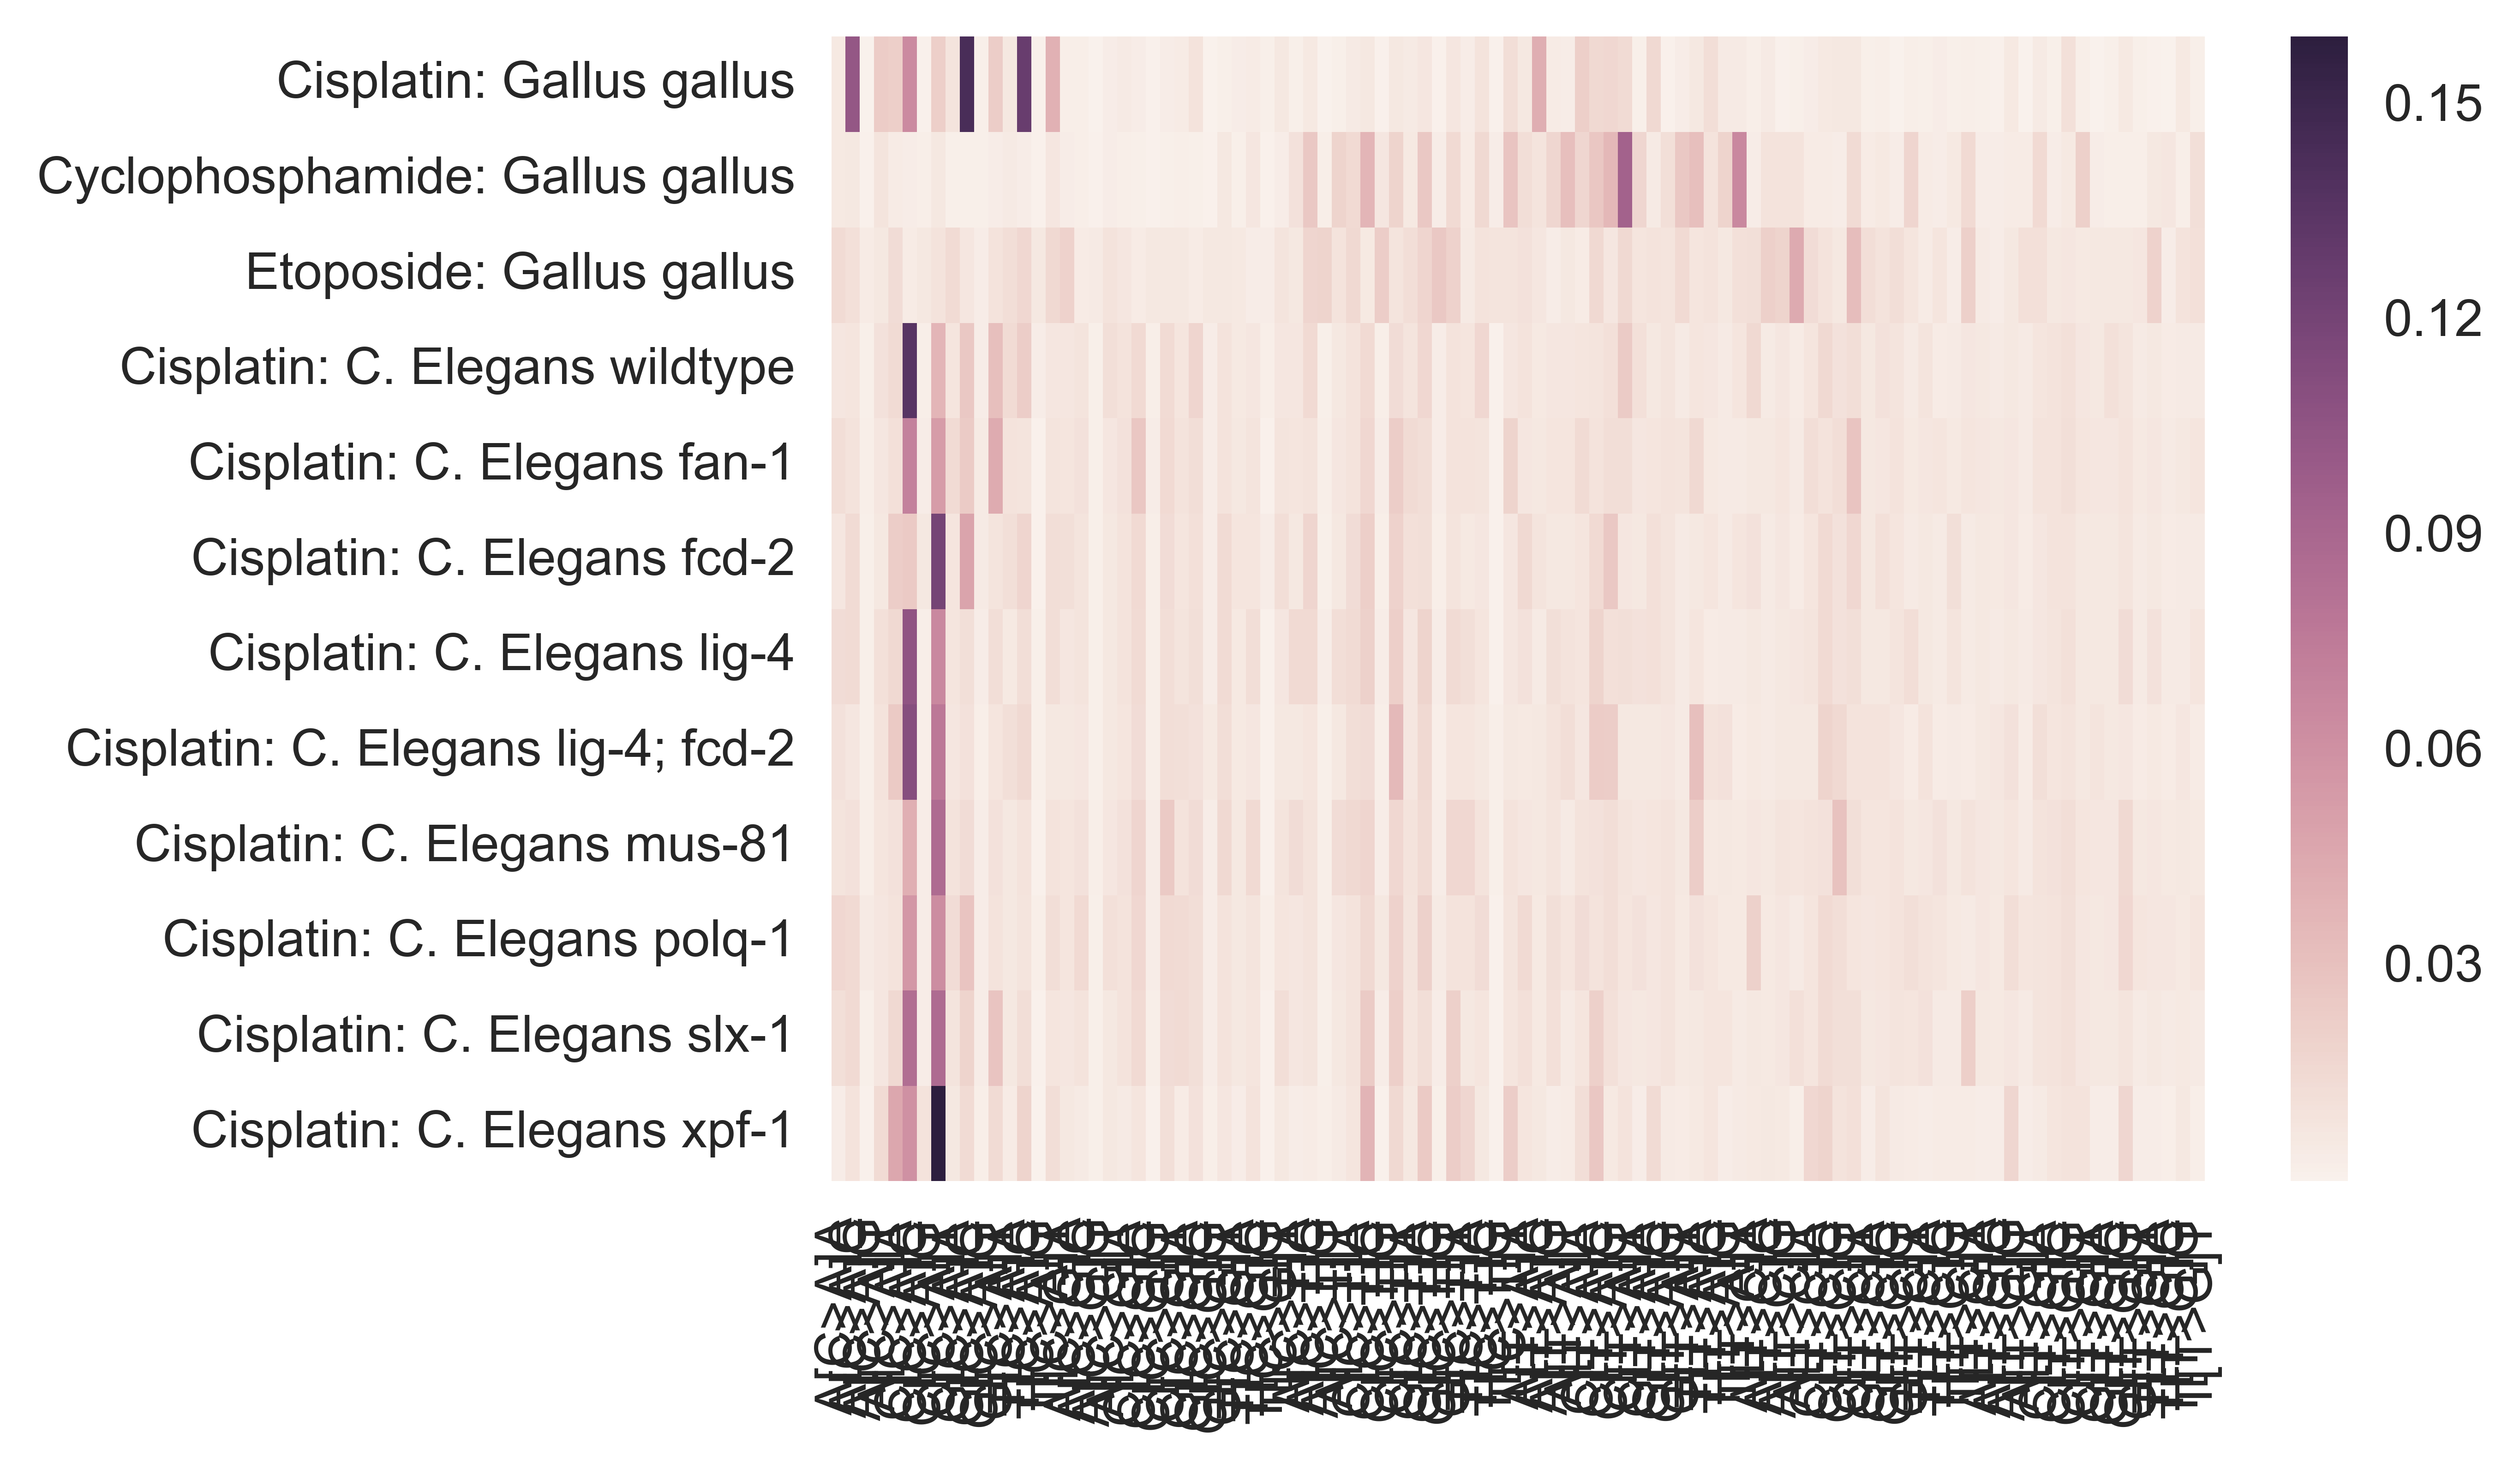

In [156]:
seaborn.heatmap(human_normalized_rates_canonicalized)

In [147]:
cosmic_signatures = pandas.read_table("../data/signatures_probabilities.txt", index_col="Somatic Mutation Type")
del cosmic_signatures["Substitution Type"]
del cosmic_signatures["Trinucleotide"]
cosmic_signatures = cosmic_signatures.dropna(1)
cosmic_signatures

,Signature 1,Signature 2,Signature 3,Signature 4,Signature 5,Signature 6,Signature 7,Signature 8,Signature 9,Signature 10,Signature 11,Signature 12,Signature 13,Signature 14,Signature 15,Signature 16,Signature 17,Signature 18,Signature 19,Signature 20,Signature 21,Signature 22,Signature 23,Signature 24,Signature 25,Signature 26,Signature 27,Signature 28,Signature 29,Signature 30
Somatic Mutation Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A[C>A]A,0.011098,6.827082e-04,0.022172,0.0365,0.014942,0.0017,0.0004,0.036718,0.0120,0.0007,0.0002,0.0077,3.347572e-04,0.0001,0.0013,0.0161,0.001832,5.053642e-02,0.0107,1.179962e-03,0.0001,0.001504,0.000453,0.028646,0.009897,2.039773e-03,0.005206,0.001397,0.069982,0.000000
A[C>A]C,0.009149,6.191072e-04,0.017872,0.0309,0.008961,0.0028,0.0005,0.033246,0.0067,0.0010,0.0010,0.0047,6.487361e-04,0.0042,0.0040,0.0097,0.000342,1.093982e-02,0.0074,2.211505e-03,0.0007,0.002451,0.000367,0.020215,0.006999,1.487162e-03,0.004738,0.000917,0.055152,0.000000
A[C>A]G,0.001490,9.927896e-05,0.002138,0.0183,0.002208,0.0005,0.0000,0.002525,0.0005,0.0003,0.0000,0.0017,3.814459e-05,0.0005,0.0000,0.0022,0.000002,2.288073e-03,0.0005,1.616910e-07,0.0000,0.000000,0.000000,0.020479,0.001448,2.839456e-04,0.000783,0.000000,0.017847,0.001967
A[C>A]T,0.006234,3.238914e-04,0.016265,0.0243,0.009207,0.0019,0.0004,0.033599,0.0068,0.0092,0.0002,0.0046,8.466585e-04,0.0296,0.0057,0.0088,0.003180,1.942409e-02,0.0074,3.008010e-03,0.0006,0.000922,0.000000,0.024600,0.004967,5.978656e-04,0.002718,0.000513,0.026805,0.000000
A[C>G]A,0.001801,2.634810e-04,0.024003,0.0097,0.011671,0.0013,0.0000,0.008357,0.0048,0.0005,0.0007,0.0031,3.775165e-03,0.0001,0.0011,0.0048,0.001662,1.516888e-03,0.0058,6.970411e-04,0.0005,0.000528,0.000000,0.011993,0.008033,1.272881e-03,0.001324,0.000255,0.009302,0.000000
A[C>G]C,0.002581,2.698660e-04,0.012160,0.0054,0.007292,0.0012,0.0000,0.004306,0.0023,0.0003,0.0003,0.0015,9.208248e-04,0.0000,0.0001,0.0024,0.001627,2.498785e-03,0.0019,2.059310e-03,0.0008,0.000000,0.000000,0.008425,0.001636,1.528195e-03,0.001771,0.000269,0.003479,0.000000
A[C>G]G,0.000593,2.192339e-04,0.005275,0.0031,0.002304,0.0000,0.0000,0.000584,0.0000,0.0000,0.0000,0.0000,1.989049e-05,0.0000,0.0006,0.0000,0.000026,2.614509e-03,0.0000,1.273496e-05,0.0000,0.000000,0.000000,0.000000,0.000000,3.072463e-04,0.000000,0.000000,0.000154,0.004820
A[C>G]T,0.002964,6.109735e-04,0.023278,0.0054,0.011696,0.0018,0.0001,0.008635,0.0038,0.0002,0.0009,0.0025,3.860632e-03,0.0001,0.0010,0.0073,0.001329,3.983011e-03,0.0072,8.485871e-04,0.0018,0.000299,0.000000,0.003881,0.003428,2.498252e-03,0.001323,0.000308,0.003977,0.000000
A[C>T]A,0.029515,7.441557e-03,0.017872,0.0120,0.021839,0.0312,0.0000,0.018067,0.0093,0.0000,0.0225,0.0121,1.480181e-03,0.0293,0.0117,0.0135,0.009350,3.825624e-03,0.0221,3.285805e-02,0.0051,0.003113,0.019767,0.006316,0.020988,5.907232e-03,0.013723,0.005434,0.005197,0.065119


In [160]:
all_signatures = cosmic_signatures.copy()
for col in human_normalized_rates_canonicalized.index:
    all_signatures[col] = human_normalized_rates_canonicalized.ix[col]
all_signatures.to_csv("../data/all_signatures.csv")
all_signatures
    

,Signature 1,Signature 2,Signature 3,Signature 4,Signature 5,Signature 6,Signature 7,Signature 8,Signature 9,Signature 10,Signature 11,Signature 12,Signature 13,Signature 14,Signature 15,Signature 16,Signature 17,Signature 18,Signature 19,Signature 20,Signature 21,Signature 22,Signature 23,Signature 24,Signature 25,Signature 26,Signature 27,Signature 28,Signature 29,Signature 30,Cisplatin: Gallus gallus,Cyclophosphamide: Gallus gallus,Etoposide: Gallus gallus,Cisplatin: C. Elegans wildtype,Cisplatin: C. Elegans fan-1,Cisplatin: C. Elegans fcd-2,Cisplatin: C. Elegans lig-4,Cisplatin: C. Elegans lig-4; fcd-2,Cisplatin: C. Elegans mus-81,Cisplatin: C. Elegans polq-1,Cisplatin: C. Elegans slx-1,Cisplatin: C. Elegans xpf-1
Somatic Mutation Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A[C>A]A,0.011098,6.827082e-04,0.022172,0.0365,0.014942,0.0017,0.0004,0.036718,0.0120,0.0007,0.0002,0.0077,3.347572e-04,0.0001,0.0013,0.0161,0.001832,5.053642e-02,0.0107,1.179962e-03,0.0001,0.001504,0.000453,0.028646,0.009897,2.039773e-03,0.005206,0.001397,0.069982,0.000000,0.005744,0.005485,0.014564,0.007297,0.012207,0.007317,0.013443,0.010682,0.008489,0.016772,0.011954,0.004010
A[C>A]C,0.009149,6.191072e-04,0.017872,0.0309,0.008961,0.0028,0.0005,0.033246,0.0067,0.0010,0.0010,0.0047,6.487361e-04,0.0042,0.0040,0.0097,0.000342,1.093982e-02,0.0074,2.211505e-03,0.0007,0.002451,0.000367,0.020215,0.006999,1.487162e-03,0.004738,0.000917,0.055152,0.000000,0.103134,0.006816,0.011263,0.008136,0.010025,0.014359,0.014043,0.007619,0.010506,0.014896,0.014764,0.009118
A[C>A]G,0.001490,9.927896e-05,0.002138,0.0183,0.002208,0.0005,0.0000,0.002525,0.0005,0.0003,0.0000,0.0017,3.814459e-05,0.0005,0.0000,0.0022,0.000002,2.288073e-03,0.0005,1.616910e-07,0.0000,0.000000,0.000000,0.020479,0.001448,2.839456e-04,0.000783,0.000000,0.017847,0.001967,0.000471,0.001085,0.004526,0.001947,0.002175,0.002004,0.001972,0.001791,0.002283,0.004736,0.002054,0.001023
A[C>A]T,0.006234,3.238914e-04,0.016265,0.0243,0.009207,0.0019,0.0004,0.033599,0.0068,0.0092,0.0002,0.0046,8.466585e-04,0.0296,0.0057,0.0088,0.003180,1.942409e-02,0.0074,3.008010e-03,0.0006,0.000922,0.000000,0.024600,0.004967,5.978656e-04,0.002718,0.000513,0.026805,0.000000,0.023438,0.008642,0.007148,0.010457,0.007501,0.006816,0.011478,0.009980,0.008196,0.007412,0.007292,0.014077
A[C>G]A,0.001801,2.634810e-04,0.024003,0.0097,0.011671,0.0013,0.0000,0.008357,0.0048,0.0005,0.0007,0.0031,3.775165e-03,0.0001,0.0011,0.0048,0.001662,1.516888e-03,0.0058,6.970411e-04,0.0005,0.000528,0.000000,0.011993,0.008033,1.272881e-03,0.001324,0.000255,0.009302,0.000000,0.002793,0.003212,0.019711,0.007243,0.008277,0.012010,0.007213,0.006671,0.008345,0.007923,0.007541,0.006387
A[C>G]C,0.002581,2.698660e-04,0.012160,0.0054,0.007292,0.0012,0.0000,0.004306,0.0023,0.0003,0.0003,0.0015,9.208248e-04,0.0000,0.0001,0.0024,0.001627,2.498785e-03,0.0019,2.059310e-03,0.0008,0.000000,0.000000,0.008425,0.001636,1.528195e-03,0.001771,0.000269,0.003479,0.000000,0.002310,0.002354,0.004319,0.008580,0.010391,0.008623,0.008578,0.007449,0.010379,0.015242,0.009235,0.004903
A[C>G]G,0.000593,2.192339e-04,0.005275,0.0031,0.002304,0.0000,0.0000,0.000584,0.0000,0.0000,0.0000,0.0000,1.989049e-05,0.0000,0.0006,0.0000,0.000026,2.614509e-03,0.0000,1.273496e-05,0.0000,0.000000,0.000000,0.000000,0.000000,3.072463e-04,0.000000,0.000000,0.000154,0.004820,0.000300,0.001082,0.004759,0.001996,0.002132,0.001895,0.001917,0.001807,0.002336,0.002114,0.002076,0.001701
A[C>G]T,0.002964,6.109735e-04,0.023278,0.0054,0.011696,0.0018,0.0001,0.008635,0.0038,0.0002,0.0009,0.0025,3.860632e-03,0.0001,0.0010,0.0073,0.001329,3.983011e-03,0.0072,8.485871e-04,0.0018,0.000299,0.000000,0.003881,0.003428,2.498252e-03,0.001323,0.000308,0.003977,0.000000,0.003858,0.003672,0.009925,0.011657,0.007667,0.007092,0.006514,0.006176,0.007717,0.011051,0.007129,0.006191
A[C>T]A,0.029515,7.441557e-03,0.017872,0.0120,0.021839,0.0312,0.0000,0.018067,0.0093,0.0000,0.0225,0.0121,1.480181e-03,0.0293,0.0117,0.0135,0.009350,3.8